# Make final classifier using mutant concentration
**Goal**: Identify patients that don't respond.
These patients we don't have to treat.

Perform the following steps:

1) Combine data with CNV.

2) Compare harmonic versus delta.

3) Compare clinical data versus clinical and genomic data.

4) Select best classification model based on AUC.

5) For this best model, compare number of molecules.

7) Make plots for parameter importance.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV

from pipelines import benchmark_pipelines, build_classifier_pipelines, pipeline_Freeman, get_classifier_init_params
from views import view_linear_model_freeman

# 1) Combine data

In [2]:
from source import read_preprocessed_data
from transform import combine_tsv_files

In [3]:
# Difference genomic variable.
X_diff, y = combine_tsv_files(
    "output/all__gene__difference__No. Mutant Molecules per mL.tsv",
    "output/all__gene__difference__CNV Score.tsv",
)

# 2) Select best model

In [4]:
y_resp = y["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']
pos_label = 'responder (pr+cr)'
y_resp = y_resp == pos_label

In [5]:
ps_class = build_classifier_pipelines()

In [6]:
# # Calculate performance using nested loop cross validation.
# b_difference = benchmark_pipelines(
#     ps_class, X, y_resp, metric='roc_auc', verbose=True,
# )

In [7]:
# # print('On average harmonic mean is better by', (b_harmonic_mean.mean(axis=1) - b_difference.mean(axis=1)).mean(), 'ROC AUC')
# b_difference

The prediction with difference instead of harmonic mean is therefore marginally worse.

In [8]:
# b = b_difference
# plt.rc('font', family='serif')
# import matplotlib
# context = {
# #     'font.size': 22,
#     'lines.linewidth': 4,
#     'figure.autolayout': True,
#     'xtick.labelsize': 'large',
#     'ytick.labelsize': 'large',
#     'legend.fontsize': 'x-large',
#     'axes.labelsize': 'xx-large',
#     'axes.titlesize': 'xx-large',
# }
# # fig = plt.figure(figsize=(4, 3))
# with plt.rc_context(context):
#     fig = plt.figure(figsize=(6, 6))
#     degrees=75
#     plt.ylabel('AUC ROC')
#     plt.xticks(rotation=degrees)
#     plt.ylim([0.4, 1.0])
#     plt.gca().fill_between([-1, 8], 0, 0.5, facecolor='grey', edgecolor='k', alpha=0.25, hatch='\\')
#     plt.errorbar(
#         b.index, 
#         b['Richard mean'], 
#         yerr=b['Richard std'], 
#         fmt='s-', 
#         markersize=10,
#         label='clinical',
#     )
#     plt.errorbar(
#         b.index, 
#         b['Freeman mean'], 
#         yerr=b['Freeman std'], 
#         fmt='o--', 
#         markersize=10,
#         label='clinical + genomic',
#     )
#     plt.legend(frameon=False)
#     plt.tight_layout()
# plt.savefig('figs/comparison_classifiers.png', bbox_inches = 'tight')
# plt.savefig('figs/comparison_classifiers.eps', bbox_inches = 'tight')

# 4) Choose model logistic regression.
The logistic regression model doesn't have the best accuracy in absolute terms, but is much simpler than the RandomForest. So by occams razor, we pick it.

In [9]:
random_state=1234

Estimator = LogisticRegression
kwargs = get_classifier_init_params(Estimator, random_state=random_state)
model = pipeline_Freeman(Estimator(**kwargs))

# 7) Make plots of the model

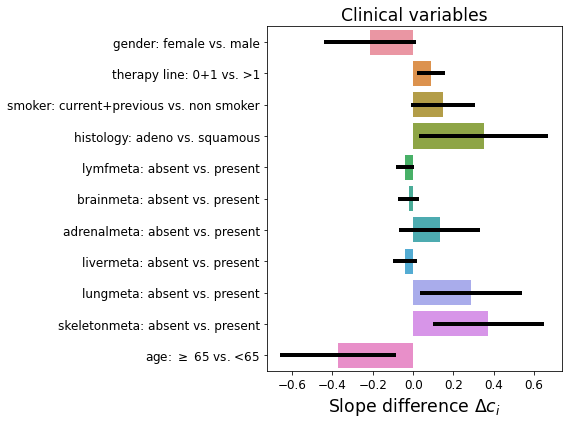

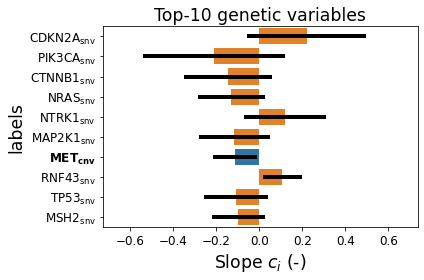

In [10]:
figure_filenames = ("logistic_regression_clinical_freeman", "logistic_regression_genetic_freeman")
view_linear_model_freeman(
    X_diff, 
    y_resp, 
    model, 
    filenames=figure_filenames, 
)